## Trabajo final módulo NLP

#### Clasificación multietiqueta de los tweets del archivo sem_eval_train.csv respecto a 11 sentimientos:
- anger
- anticipation
- disgust
- fear
- joy
- love
- optimism
- pessimism
- sadness
- surprise
- trust

#### Cada tweet puede pertenecer a varias clases

### En este notebook probaré un modelo sencillo usando una RNN para un clasificador Multi clase.

In [1]:
import pandas as pd
import re, string, spacy
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Embedding, SpatialDropout1D, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


2024-09-05 20:48:03.752036: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-05 20:48:03.807563: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-05 20:48:03.809599: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-09-05 20:48:03.809606: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc

In [2]:
RNN_DIM = 75
RNN_layer = GRU

In [3]:
df = pd.read_csv('sem_eval_train_es.csv', index_col='ID')

df

,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
ID,,,,,,,,,,,,
2018-Es-01643,@aliciaenp Ajajjaa somos del clan twitteras pe...,False,False,False,False,True,False,False,False,False,False,False
2018-Es-05142,@AwadaNai la mala suerte del gato fichame la c...,False,False,False,True,False,False,False,True,False,False,False
2018-Es-05379,@audiomano A mí tampoco me agrado mucho eso. E...,True,False,False,False,False,False,False,False,False,False,False
2018-Es-00208,Para llevar a los bebes de un lugar a otro deb...,False,False,False,False,True,False,False,False,False,False,False
2018-Es-01385,@DalasReview me encanta la terrible hipocresia...,True,False,True,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-Es-06340,Ahorita quisiera que mi preocupación más grand...,False,False,False,True,False,False,False,True,True,False,False
2018-Es-00439,El mayor criminal del país diciéndole “delincu...,True,False,True,False,False,False,False,False,False,False,False
2018-Es-04919,Mi prima de 4 años se ha enfadado conmigo porq...,True,False,False,False,False,False,False,False,False,True,False


In [4]:
nlp = spacy.load('es_core_news_md')

pattern2 = re.compile('[{}]'.format(re.escape(string.punctuation)))

def clean_text(text, lemas=False):
    text = re.sub(r'@[\w_]+|https?://[\w_./]+', '', text)
    tokens = nlp(text)
    tokens = [tok.lemma_.lower() if lemas else tok.lower_ for tok in tokens if not tok.is_punct]
    filtered_tokens = [pattern2.sub('', tok) for tok in tokens]
    filtered_text = ' '.join(filtered_tokens)

    return filtered_text

In [5]:
df.Tweet = df.Tweet.apply(clean_text, lemas = True)
df[df['Tweet'] != '']

label_columns = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 
                 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']
df[label_columns] = df[label_columns].astype(int)
Y = df[label_columns].values

# Separar los datos en entrenamiento y prueba
tweets_train, tweets_test, Y_train, Y_test = train_test_split(df.Tweet, Y, 
    test_size=0.2, random_state=0)

In [6]:
cv = CountVectorizer(min_df=2)
cv.fit(tweets_train)
max_features = len(cv.get_feature_names_out())
max_features

2003

In [7]:
MAX_NB_WORDS = max_features+2
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, split = ' ', oov_token='OOV')
tokenizer.fit_on_texts(tweets_train.values)

X_train = tokenizer.texts_to_sequences(tweets_train.values)
X_train = pad_sequences(X_train, padding='post')

word_index = tokenizer.word_index
print(f'Found {len(word_index)} unique tokens.')

MAX_SEQUENCE_LENGTH = X_train.shape[1]
X_test = tokenizer.texts_to_sequences(tweets_test.values)
X_test = pad_sequences(X_test, padding='post', maxlen=MAX_SEQUENCE_LENGTH)

Found 6378 unique tokens.


In [8]:
nlp = spacy.load('es_core_news_md')

EMBREDDING_DIM = nlp.vocab.vectors_length
embedding_matrix = np.zeros((MAX_NB_WORDS, EMBREDDING_DIM))
vectores = 0

for word, i in word_index.items():
    if(i<MAX_NB_WORDS):
        if nlp.vocab[word].has_vector:
            embedding_matrix[i] = nlp.vocab[word].vector
            vectores += 1

In [14]:
embedding_layer = Embedding(MAX_NB_WORDS,
                            EMBREDDING_DIM,
                            weights = [embedding_matrix],
                            input_length = MAX_SEQUENCE_LENGTH,
                            trainable = False,
                            mask_zero = True)

model = Sequential()
model.add(embedding_layer)
model.add(SpatialDropout1D(0.5))
model.add(GRU(300, dropout=0.45, recurrent_dropout=0.45, return_sequences=True))
model.add(GRU(200, dropout=0.45, recurrent_dropout=0.45, return_sequences=True))
model.add(GRU(100, dropout=0.45, recurrent_dropout=0.45))
model.add(Dense(11, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 32, 300)           601500    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 32, 300)          0         
 lDropout1D)                                                     
                                                                 
 gru_3 (GRU)                 (None, 32, 300)           541800    
                                                                 
 gru_4 (GRU)                 (None, 32, 200)           301200    
                                                                 
 gru_5 (GRU)                 (None, 100)               90600     
                                                                 
 dense_1 (Dense)             (None, 11)                1111      
                                                      

In [19]:
batch_size = 64
epochs = 100
filepath='weights.best.hdf5'

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose = 1, save_best_only = True, mode = 'max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=0)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=30, verbose=1, mode='max', restore_best_weights=False)

callbacks_list = [checkpoint, reduce_lr, early_stopping]
history = model.fit(X_train, Y_train, epochs=100,
                    batch_size=batch_size, verbose=1,
                    validation_data=(X_test, Y_test),
                    callbacks = callbacks_list)

Epoch 1/100
45/45 [==============================] - ETA: 0s - loss: 0.2828 - accuracy: 0.5186
Epoch 1: val_accuracy improved from -inf to 0.48247, saving model to weights.best.hdf5
45/45 [==============================] - 4s 92ms/step - loss: 0.2828 - accuracy: 0.5186 - val_loss: 0.3363 - val_accuracy: 0.4825 - lr: 5.0000e-04
Epoch 2/100
45/45 [==============================] - ETA: 0s - loss: 0.2850 - accuracy: 0.5098
Epoch 2: val_accuracy improved from 0.48247 to 0.49229, saving model to weights.best.hdf5
45/45 [==============================] - 4s 86ms/step - loss: 0.2850 - accuracy: 0.5098 - val_loss: 0.3359 - val_accuracy: 0.4923 - lr: 5.0000e-04
Epoch 3/100
45/45 [==============================] - ETA: 0s - loss: 0.2800 - accuracy: 0.5267
Epoch 3: val_accuracy did not improve from 0.49229
45/45 [==============================] - 4s 86ms/step - loss: 0.2800 - accuracy: 0.5267 - val_loss: 0.3377 - val_accuracy: 0.4881 - lr: 5.0000e-04
Epoch 4/100
45/45 [===========================

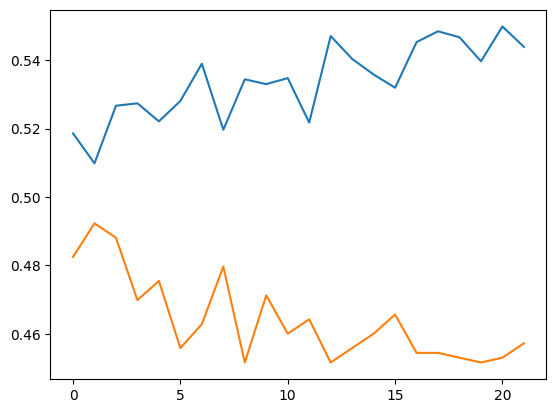

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [21]:
score, acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size=batch_size)

print('score: %.2f' % (score))
print('acc: %.2f' % (acc))

12/12 - 0s - loss: 0.3359 - accuracy: 0.4923 - 232ms/epoch - 19ms/step
score: 0.34
acc: 0.49


In [22]:
predict = model.predict(X_test, batch_size = 1)
prediccion = (predict>0.5).astype(int)

target_names = [
    "anger", "anticipation", "disgust", "fear",
    "joy", "love", "optimism", "pessimism",
    "sadness", "surprise", "trust"
]
from sklearn.metrics import classification_report

print(classification_report(Y_test, prediccion, target_names=target_names))

713/713 [==============================] - 7s 10ms/step
              precision    recall  f1-score   support

       anger       0.64      0.57      0.60       234
anticipation       0.31      0.04      0.08        92
     disgust       0.34      0.19      0.25        93
        fear       0.56      0.43      0.49        72
         joy       0.70      0.68      0.69       207
        love       0.68      0.31      0.43        54
    optimism       0.43      0.08      0.14        73
   pessimism       0.68      0.18      0.28       128
     sadness       0.72      0.46      0.56       164
    surprise       1.00      0.03      0.05        40
       trust       1.00      0.07      0.13        43

   micro avg       0.63      0.38      0.47      1200
   macro avg       0.64      0.28      0.34      1200
weighted avg       0.62      0.38      0.43      1200
 samples avg       0.51      0.40      0.43      1200



/home/vic263/anaconda3/envs/trabajonlp_tf2_11/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vic263/anaconda3/envs/trabajonlp_tf2_11/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vic263/anaconda3/envs/trabajonlp_tf2_11/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag